Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil
shutil.copytree('/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/training_data/Ensemble/', '/content/training_data/')

In [ ]:
!pip install scikit-learn
!pip install joblib soundfile speechpy librosa matplotlib
!pip install joblib==1.2.0
!pip install np_utils

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
#from keras.utils import np_utils
import joblib
import os

dendritic_caps_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/Dendritic_CapsNets.tf")
dendritic_caps_model.summary()

clstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/conv_lstm_classifier.tf")
clstm_model.summary()


Stacking

After Reshape
x_train.shape :(798, 1047, 40, 1)    y_train.shape:(798, 8)
x_test.shape :(200, 1047, 40, 1)    y_test.shape:(200, 8)
dendritic_caps_model
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1047, 40, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1045, 38, 128)     1280      
                                                                 
 conv2d_3 (Conv2D)           (None, 1043, 36, 32)      36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 521, 18, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 521, 18, 32)       0         
                                      

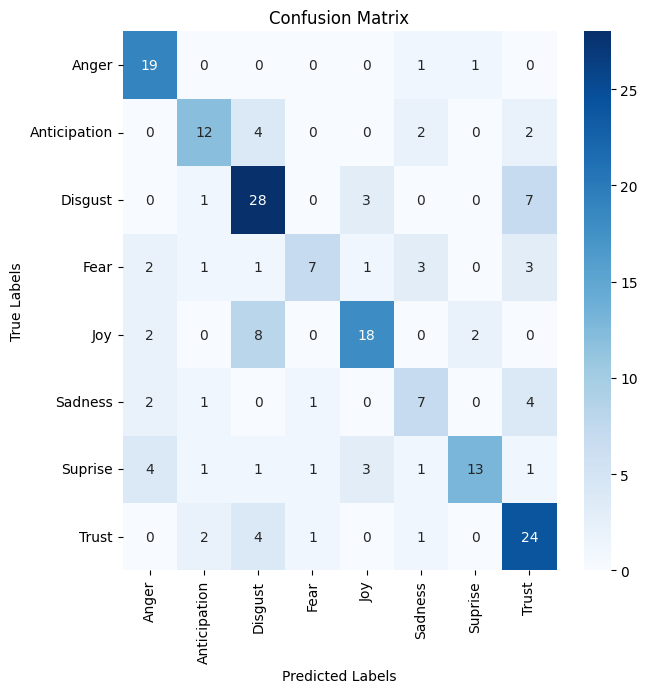

Confusion Matrix:
 [[19  0  0  0  0  1  1  0]
 [ 0 12  4  0  0  2  0  2]
 [ 0  1 28  0  3  0  0  7]
 [ 2  1  1  7  1  3  0  3]
 [ 2  0  8  0 18  0  2  0]
 [ 2  1  0  1  0  7  0  4]
 [ 4  1  1  1  3  1 13  1]
 [ 0  2  4  1  0  1  0 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.90      0.76        21
           1       0.67      0.60      0.63        20
           2       0.61      0.72      0.66        39
           3       0.70      0.39      0.50        18
           4       0.72      0.60      0.65        30
           5       0.47      0.47      0.47        15
           6       0.81      0.52      0.63        25
           7       0.59      0.75      0.66        32

    accuracy                           0.64       200
   macro avg       0.65      0.62      0.62       200
weighted avg       0.66      0.64      0.63       200



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix

#from keras.utils import np_utils
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
###################################################
def load_data(load_from_file,name):
    if load_from_file:
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = '/content/training_data'

        x_train = joblib.load(os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        x_test = joblib.load(os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        y_train = joblib.load(os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        y_test = joblib.load(os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        num_labels = joblib.load(os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #data = joblib.load(os.path.join(save_dir, 'data_'+name+'.joblib'))
        #labels = joblib.load(os.path.join(save_dir, 'labels_'+name+'.joblib'))
    else:
        #x_train, x_test, y_train, y_test, num_labels = extract_data()
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = current_dir + subdir
        joblib.dump(x_train, os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        joblib.dump(x_test, os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        joblib.dump(y_train, os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        joblib.dump(y_test, os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        joblib.dump(num_labels, os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #joblib.dump(data, os.path.join(save_dir, 'data_'+name+'.joblib'))
        #joblib.dump(labels, os.path.join(save_dir, 'labels_'+name+'.joblib'))
    return x_train,x_test,y_train,y_test,num_labels#,data, labels
###################################################
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

def create_stacked_model(clstm_model, dendritic_model, input_shape):
    inputs = Input(shape=input_shape)

    # Forward pass through the individual models
    clstm_out = clstm_model(inputs)
    dendritic_out = dendritic_model(inputs)

    # Concatenate outputs
    concatenated = Concatenate()([clstm_out, dendritic_out])

    # Additional Dense layer (optional)
    out = layers.Dense(8, activation='softmax')(concatenated)

    # Create and return the model
    model = Model(inputs, out)
    return model

#loadfromfile=False
loadfromfile=True
x_train,x_test,y_train,y_test,num_labels =load_data(load_from_file=loadfromfile,name= 'Ensemble')

from keras import utils
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
in_shape = x_train[0].shape

x_train = x_train.reshape(x_train.shape[0], in_shape[1], in_shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[1], in_shape[0], 1)

print("After Reshape")
print("x_train.shape :" +  str(x_train.shape) +"    y_train.shape:"+ str(y_train.shape))
print("x_test.shape :" +  str(x_test.shape) +"    y_test.shape:"+ str(y_test.shape))

num_timesteps, num_features = x_train.shape[1], x_train.shape[2]
num_classes = 8   #y1_train.shape[1]

###################################################
#Step 5: Generate Predictions from Base Models
#with tf.device('/cpu:0'):
#   x_train = tf.convert_to_tensor(x_train, np.float32)
#   y_train = tf.convert_to_tensor(y_train, np.float32)

dendritic_caps_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/Dendritic_CapsNets.tf")
print("dendritic_caps_model")
dendritic_caps_model.summary()
clstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/conv_lstm_classifier.tf")
print("clstm_model")
clstm_model.summary()

# Assume (None, 28, 28, 1) input shape for demonstration
input_shape = (num_timesteps, num_features, 1)

# Create individual models
#clstm_model = create_clstm_model(input_shape)
#dendritic_model = create_dendritic_model(input_shape)

# Create stacked model
stacked_model = create_stacked_model(clstm_model, dendritic_caps_model, input_shape)

# Compile
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("stacked_model")
stacked_model.summary()

# Train (you'll need to provide your train and test data)
history = stacked_model.fit(x_train, y_train,  batch_size=32, epochs=50,shuffle=True,validation_data=(x_test,y_test))

loss, acc = stacked_model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(acc*100))
print("Loss: {:.2f}%".format(loss*100))
print("Highest Accuracy: {:.2f}%".format(max(history.history['val_accuracy'])*100))

y_pred = stacked_model.predict(x_test)
y_pred_classes = [np.argmax(y) for y in y_pred]
y_true_classes = [np.argmax(y) for y in y_test]

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

# Plot the confusion matrix
#labels = [str(i) for i in np.unique(np.concatenate((test_labels, predicted_labels)))]
labels = ["Anger", "Anticipation","Disgust","Fear","Joy","Sadness","Suprise","Trust"]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
#from keras.utils import np_utils
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, Reshape, Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
###################################################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
###################################################
def load_data(load_from_file,name):
    if load_from_file:
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = '/content/training_data'

        x_train = joblib.load(os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        x_test = joblib.load(os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        y_train = joblib.load(os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        y_test = joblib.load(os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        num_labels = joblib.load(os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #data = joblib.load(os.path.join(save_dir, 'data_'+name+'.joblib'))
        #labels = joblib.load(os.path.join(save_dir, 'labels_'+name+'.joblib'))
    else:
        #x_train, x_test, y_train, y_test, num_labels = extract_data()
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = current_dir + subdir
        joblib.dump(x_train, os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        joblib.dump(x_test, os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        joblib.dump(y_train, os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        joblib.dump(y_test, os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        joblib.dump(num_labels, os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #joblib.dump(data, os.path.join(save_dir, 'data_'+name+'.joblib'))
        #joblib.dump(labels, os.path.join(save_dir, 'labels_'+name+'.joblib'))
    return x_train,x_test,y_train,y_test,num_labels#,data, labels
###################################################
#loadfromfile=False
loadfromfile=True
x_train,x_test,y_train,y_test,num_labels =load_data(load_from_file=loadfromfile,name= 'Ensemble')
from keras import utils
###################################################
###################################################
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
###################################################
###################################################
in_shape = x_train[0].shape
x_train = x_train.reshape(x_train.shape[0], in_shape[1], in_shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[1], in_shape[0], 1)
num_timesteps, num_features = x_train.shape[1], x_train.shape[2]
num_classes = 8   #y1_train.shape[1]
###################################################
dendritic_caps_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/Dendritic_CapsNets.tf")
print("dendritic_caps_model")
#dendritic_caps_model.summary()
clstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/conv_lstm_classifier.tf")
print("clstm_model")
#clstm_model.summary()
###################################################
train_images=x_train
train_labels=y_train
test_images=x_test
test_labels=y_test

# Normalize pixel values between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

#clstm_model.fit(train_images, train_labels, epochs=1)

############################
model = clstm_model#dendritic_caps_model
############################
print("\n\n\n\n*******************************")

# Get the model predictions
predictions = model.predict(test_images)

# Convert logits to softmax probabilities
predictions = tf.nn.softmax(predictions).numpy()

# Extract the predicted class for each example in the test set
predicted_labels = predictions.argmax(axis=-1)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(acc*100))
print("Loss: {:.2f}%".format(loss*100))


# Create a confusion matrix
#conf_matrix = confusion_matrix(test_labels,predicted_labels )
#classification_rep = classification_report(test_labels,predicted_labels)

y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(y) for y in y_pred]
y_true_classes = [np.argmax(y) for y in y_test]

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

# Plot the confusion matrix
#labels = [str(i) for i in np.unique(np.concatenate((test_labels, predicted_labels)))]
labels = ["Anger", "Anticipation","Disgust","Fear","Joy","Sadness","Suprise","Trust"]

import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)



Boosting

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
#from keras.utils import np_utils
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, Reshape, Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss, classification_report  # Import relevant metrics
###################################################
def load_data(load_from_file,name):
    if load_from_file:
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = '/content/training_data'

        x_train = joblib.load(os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        x_test = joblib.load(os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        y_train = joblib.load(os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        y_test = joblib.load(os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        num_labels = joblib.load(os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #data = joblib.load(os.path.join(save_dir, 'data_'+name+'.joblib'))
        #labels = joblib.load(os.path.join(save_dir, 'labels_'+name+'.joblib'))
    else:
        #x_train, x_test, y_train, y_test, num_labels = extract_data()
        current_dir = os.getcwd()
        subdir = '\\training_data\\'
        save_dir = current_dir + subdir
        joblib.dump(x_train, os.path.join(save_dir, 'x_train_'+name+'.joblib'))
        joblib.dump(x_test, os.path.join(save_dir, 'x_test_'+name+'.joblib'))
        joblib.dump(y_train, os.path.join(save_dir, 'y_train_'+name+'.joblib'))
        joblib.dump(y_test, os.path.join(save_dir, 'y_test_'+name+'.joblib'))
        joblib.dump(num_labels, os.path.join(save_dir, 'num_labels_'+name+'.joblib'))
        #joblib.dump(data, os.path.join(save_dir, 'data_'+name+'.joblib'))
        #joblib.dump(labels, os.path.join(save_dir, 'labels_'+name+'.joblib'))
    return x_train,x_test,y_train,y_test,num_labels#,data, labels
###################################################
#loadfromfile=False
loadfromfile=True
x_train,x_test,y_train,y_test,num_labels =load_data(load_from_file=loadfromfile,name= 'Ensemble')

from keras import utils
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
in_shape = x_train[0].shape

x_train = x_train.reshape(x_train.shape[0], in_shape[1], in_shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[1], in_shape[0], 1)

print("After Reshape")
print("x_train.shape :" +  str(x_train.shape) +"    y_train.shape:"+ str(y_train.shape))
print("x_test.shape :" +  str(x_test.shape) +"    y_test.shape:"+ str(y_test.shape))

num_timesteps, num_features = x_train.shape[1], x_train.shape[2]
num_classes = 8   #y1_train.shape[1]
###################################################
from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model


dendritic_caps_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/Dendritic_CapsNets.tf")
print("dendritic_caps_model")
dendritic_caps_model.summary()
clstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Personal/Study/Phd/Python/Examples/4.C-LSTM/model/conv_lstm_classifier.tf")
print("clstm_model")
clstm_model.summary()

n_models = 2  # Number of models
models = []

models.append(dendritic_caps_model)
models.append(clstm_model)

def ensemble_predictions(models, x):
    predictions = np.zeros((len(x), 8))

    for model in models:
        pred = model.predict(x)
        predictions += pred
        classification_rep = classification_report(y_true_classes, y_pred_classes)
        print("\nClassification Report:\n", classification_rep)

    return np.argmax(predictions, axis=1)


def ensemble_loss(models, x, y_true):
    predictions = np.zeros((len(x), 8))

    for model in models:
        pred = model.predict(x)
        predictions += pred  # Accumulate predictions

    # Compute the ensemble loss (cross-entropy for classification)
    ensemble_loss = log_loss(y_true, predictions)

    # Print the classification report for each model (optional)
    for model in models:
        y_pred_classes = np.argmax(model.predict(x), axis=1)
        classification_rep = classification_report(y_true, y_pred_classes)
        print("\nClassification Report:\n", classification_rep)

    return ensemble_loss


#ensemble_pred = ensemble_predictionsx(models, x_test, y_test)
ensemble_pred = ensemble_predictions(models, x_test)
y_true = np.argmax(y_test, axis=1)

accuracy = np.mean(ensemble_pred == y_true)
print(f'Boosting-like Ensemble Accuracy: {accuracy * 100:.2f}%')

#*************************************************
y_true_classes = [np.argmax(y) for y in y_test]
ensemble_loss_value = ensemble_loss(models, x_test, y_true_classes)
print(f"Ensemble Loss: {ensemble_loss_value:.4f}")
#*************************************************


After Reshape
x_train.shape :(798, 1047, 40, 1)    y_train.shape:(798, 8)
x_test.shape :(200, 1047, 40, 1)    y_test.shape:(200, 8)
dendritic_caps_model
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1047, 40, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1045, 38, 128)     1280      
                                                                 
 conv2d_3 (Conv2D)           (None, 1043, 36, 32)      36896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 521, 18, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 521, 18, 32)       0         
                                      